In [1]:
from IPython.display import Markdown, display

display(Markdown("# 05_trend_analysis.ipynb"))
display(Markdown("### Philippine Temperature Analysis (2010–present) — Trend Analysis & Anomaly Detection"))
display(Markdown("""
This notebook analyzes **long-term temperature trends, anomalies, and seasonal patterns** per city in the Philippines.
It includes **annual and seasonal trends**, rolling averages, and highlights **extreme deviations** in temperature.
"""))

# 05_trend_analysis.ipynb

### Philippine Temperature Analysis (2010–present) — Trend Analysis & Anomaly Detection


This notebook analyzes **long-term temperature trends, anomalies, and seasonal patterns** per city in the Philippines.
It includes **annual and seasonal trends**, rolling averages, and highlights **extreme deviations** in temperature.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import plotly.express as px

sns.set_style("whitegrid")

In [3]:
data_path = "../data/processed/phil_temp_2010_2024.csv"
df = pd.read_csv(data_path)

df['datetime'] = pd.to_datetime(df['datetime'], errors='coerce')

df['year'] = df['datetime'].dt.year
df['month'] = df['datetime'].dt.month

display(df.head())
display(df.info())
display(df.isna().sum())
display(f"Duplicate rows: {df.duplicated().sum()}")

,city_name,datetime,temperature_2m_mean,temperature_2m_max,temperature_2m_min,apparent_temperature_max,apparent_temperature_min,year,month
0,Alaminos,2010-01-01,26.6,29.9,24.8,32.0,26.5,2010,1
1,Alaminos,2010-01-02,26.7,29.4,25.0,32.1,27.4,2010,1
2,Alaminos,2010-01-03,26.0,27.6,24.5,30.9,28.6,2010,1
3,Alaminos,2010-01-04,25.9,28.8,23.1,33.6,27.5,2010,1
4,Alaminos,2010-01-05,26.4,28.5,24.5,33.7,28.8,2010,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 552212 entries, 0 to 552211
Data columns (total 9 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   city_name                 552212 non-null  object        
 1   datetime                  552212 non-null  datetime64[ns]
 2   temperature_2m_mean       552212 non-null  float64       
 3   temperature_2m_max        552212 non-null  float64       
 4   temperature_2m_min        552212 non-null  float64       
 5   apparent_temperature_max  500324 non-null  float64       
 6   apparent_temperature_min  500324 non-null  float64       
 7   year                      552212 non-null  int32         
 8   month                     552212 non-null  int32         
dtypes: datetime64[ns](1), float64(5), int32(2), object(1)
memory usage: 33.7+ MB


None

city_name                       0
datetime                        0
temperature_2m_mean             0
temperature_2m_max              0
temperature_2m_min              0
apparent_temperature_max    51888
apparent_temperature_min    51888
year                            0
month                           0
dtype: int64

'Duplicate rows: 0'

In [4]:
annual_city = df.groupby(['city_name','year']).agg({
    'temperature_2m_mean':'mean',
    'temperature_2m_max':'mean',
    'temperature_2m_min':'mean',
    'apparent_temperature_max':'mean',
    'apparent_temperature_min':'mean'
}).reset_index()

display(annual_city.head())

,city_name,year,temperature_2m_mean,temperature_2m_max,temperature_2m_min,apparent_temperature_max,apparent_temperature_min
0,Alaminos,2010,27.627397,30.002192,25.895890,35.730685,29.971507
1,Alaminos,2011,26.965205,29.011781,25.436986,34.300274,29.130685
2,Alaminos,2012,27.321038,29.448634,25.754098,34.765574,29.777322
3,Alaminos,2013,27.473699,29.605753,25.867397,35.043562,29.873425
4,Alaminos,2014,27.279452,29.457260,25.636712,34.912877,29.547123


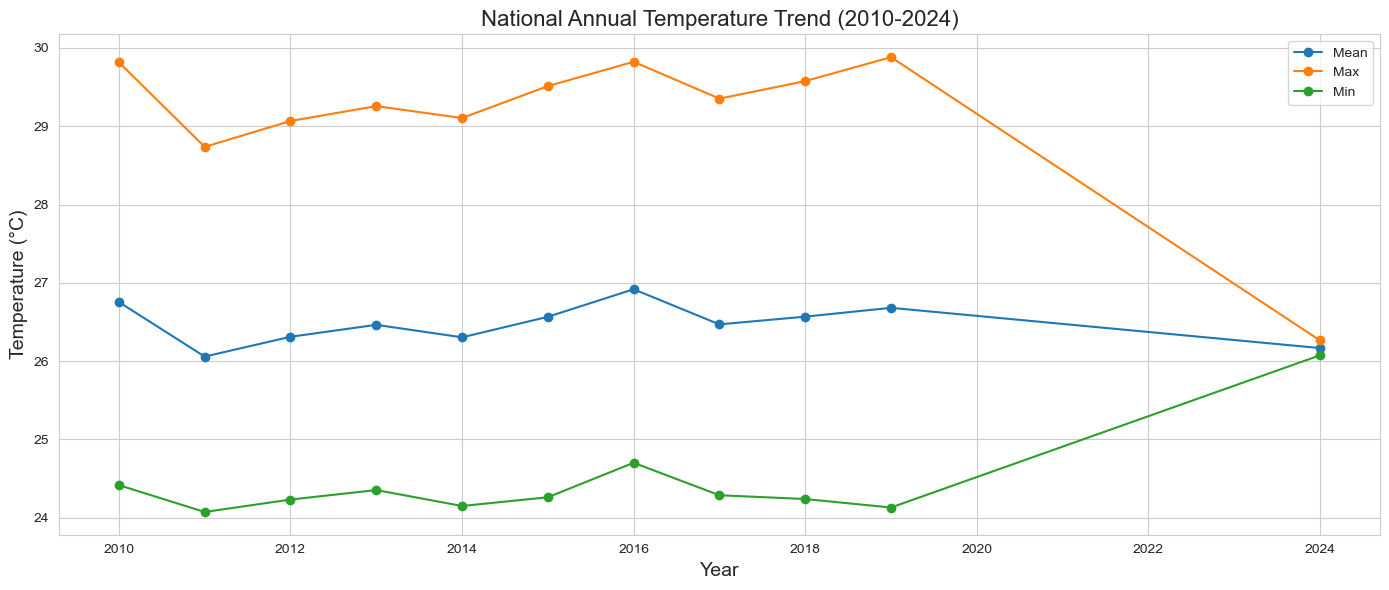

In [5]:
annual_national = df.groupby('year').agg({
    'temperature_2m_mean':'mean',
    'temperature_2m_max':'mean',
    'temperature_2m_min':'mean'
}).reset_index()

plt.figure(figsize=(14,6))
plt.plot(annual_national['year'], annual_national['temperature_2m_mean'], marker='o', label='Mean')
plt.plot(annual_national['year'], annual_national['temperature_2m_max'], marker='o', label='Max')
plt.plot(annual_national['year'], annual_national['temperature_2m_min'], marker='o', label='Min')
plt.title("National Annual Temperature Trend (2010-2024)", fontsize=16)
plt.xlabel("Year", fontsize=14)
plt.ylabel("Temperature (°C)", fontsize=14)
plt.legend()
plt.tight_layout()
plt.show()

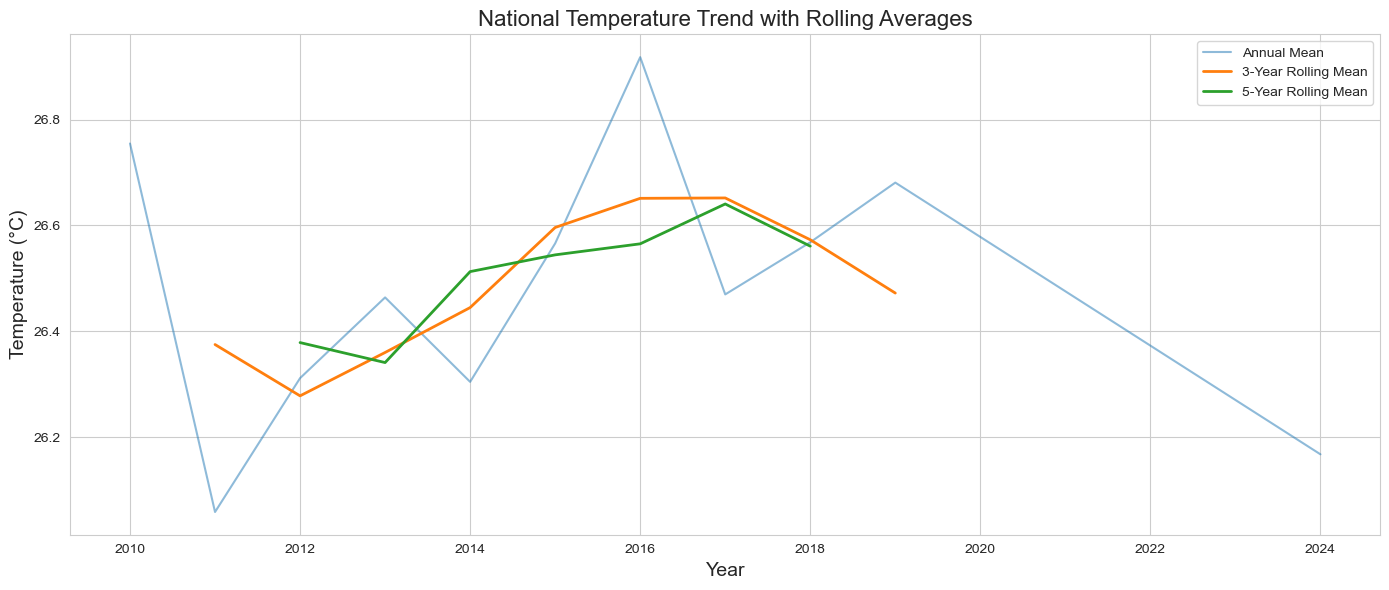

In [6]:
annual_national['mean_3yr'] = annual_national['temperature_2m_mean'].rolling(3, center=True).mean()
annual_national['mean_5yr'] = annual_national['temperature_2m_mean'].rolling(5, center=True).mean()

plt.figure(figsize=(14,6))
plt.plot(annual_national['year'], annual_national['temperature_2m_mean'], label='Annual Mean', alpha=0.5)
plt.plot(annual_national['year'], annual_national['mean_3yr'], label='3-Year Rolling Mean', linewidth=2)
plt.plot(annual_national['year'], annual_national['mean_5yr'], label='5-Year Rolling Mean', linewidth=2)
plt.title("National Temperature Trend with Rolling Averages", fontsize=16)
plt.xlabel("Year", fontsize=14)
plt.ylabel("Temperature (°C)", fontsize=14)
plt.legend()
plt.tight_layout()
plt.show()

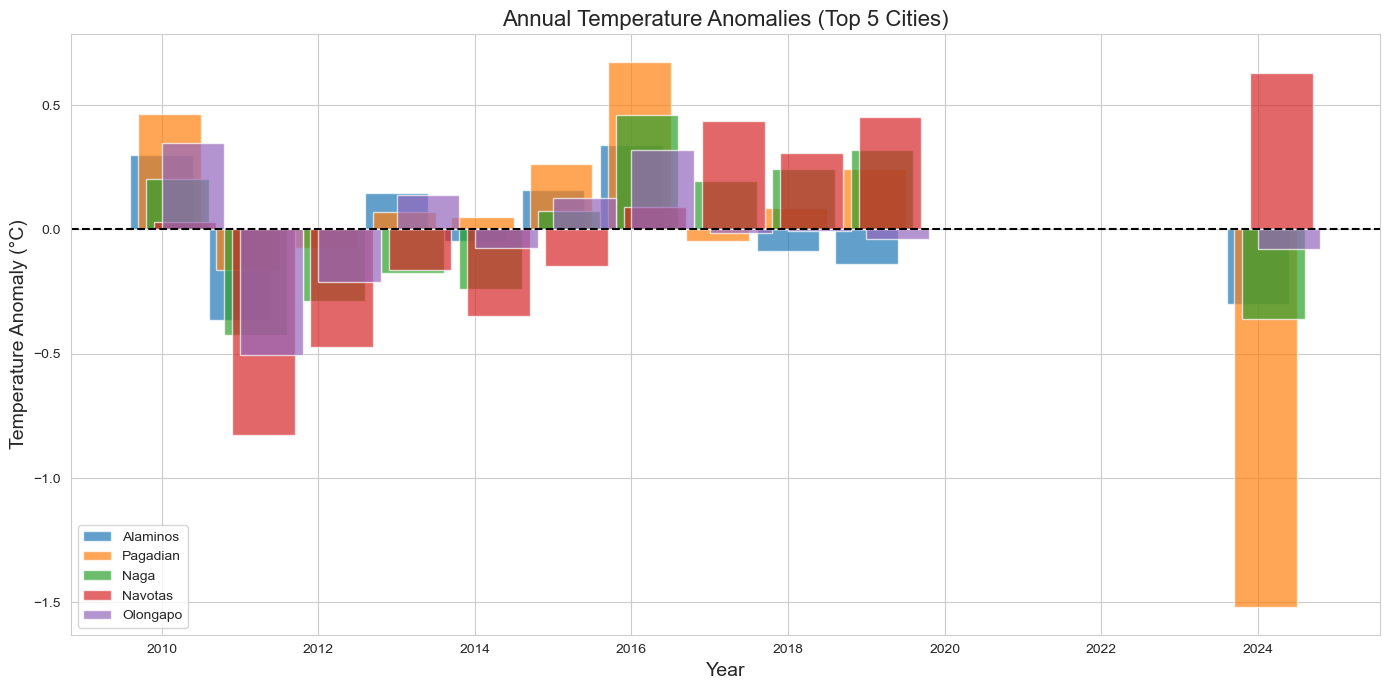

In [7]:
long_term_mean = df.groupby('city_name')['temperature_2m_mean'].mean().reset_index()
long_term_mean = long_term_mean.rename(columns={'temperature_2m_mean':'long_term_mean'})

annual_city_anom = annual_city.merge(long_term_mean, on='city_name')
annual_city_anom['temp_anomaly'] = annual_city_anom['temperature_2m_mean'] - annual_city_anom['long_term_mean']

# Visualize anomalies for top cities
top_cities = df['city_name'].value_counts().index[:5]

plt.figure(figsize=(14,7))
for city in top_cities:
    city_data = annual_city_anom[annual_city_anom['city_name']==city]
    plt.bar(city_data['year'] + 0.1*top_cities.get_loc(city), city_data['temp_anomaly'], label=city, alpha=0.7)

plt.axhline(0, color='black', linestyle='--')
plt.title("Annual Temperature Anomalies (Top 5 Cities)", fontsize=16)
plt.xlabel("Year", fontsize=14)
plt.ylabel("Temperature Anomaly (°C)", fontsize=14)
plt.legend()
plt.tight_layout()
plt.show()

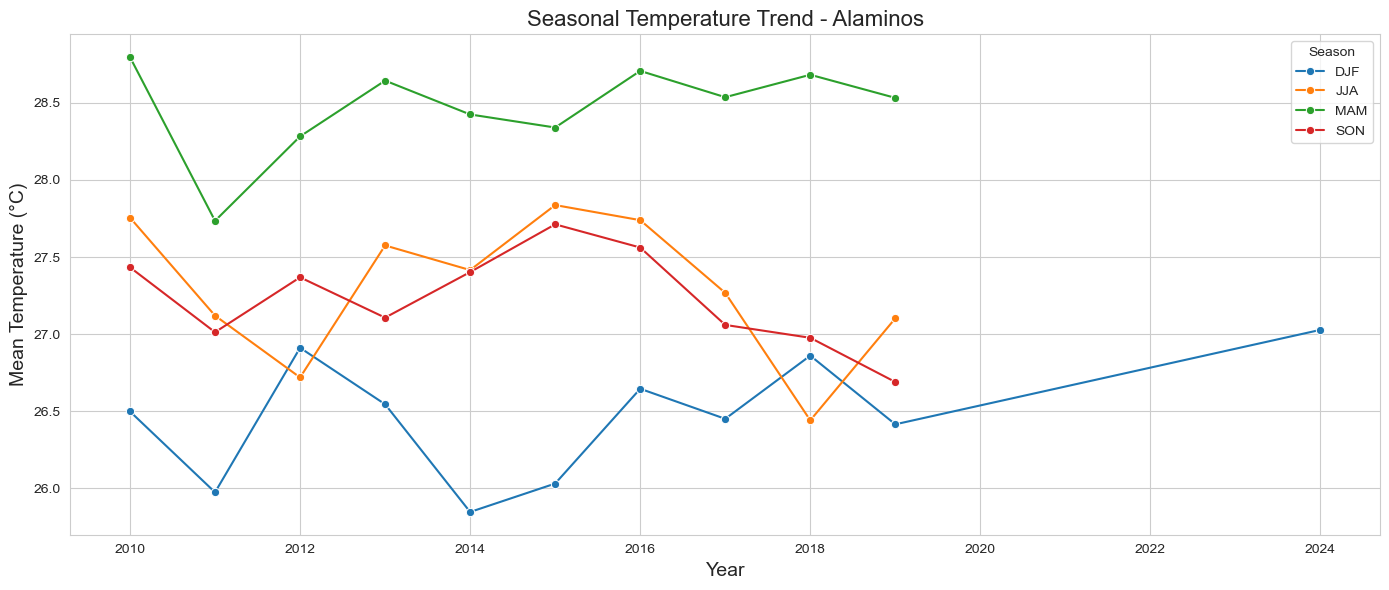

In [8]:
def month_to_season(month):
    if month in [12,1,2]: return 'DJF'
    elif month in [3,4,5]: return 'MAM'
    elif month in [6,7,8]: return 'JJA'
    else: return 'SON'

df['month'] = df['datetime'].dt.month
df['season'] = df['month'].apply(month_to_season)

seasonal_trend = df.groupby(['city_name','year','season']).agg({
    'temperature_2m_mean':'mean'
}).reset_index()

city_example = top_cities[0]
city_seasonal = seasonal_trend[seasonal_trend['city_name']==city_example]

plt.figure(figsize=(14,6))
sns.lineplot(data=city_seasonal, x='year', y='temperature_2m_mean', hue='season', marker='o')
plt.title(f"Seasonal Temperature Trend - {city_example}", fontsize=16)
plt.xlabel("Year", fontsize=14)
plt.ylabel("Mean Temperature (°C)", fontsize=14)
plt.legend(title='Season')
plt.tight_layout()
plt.show()

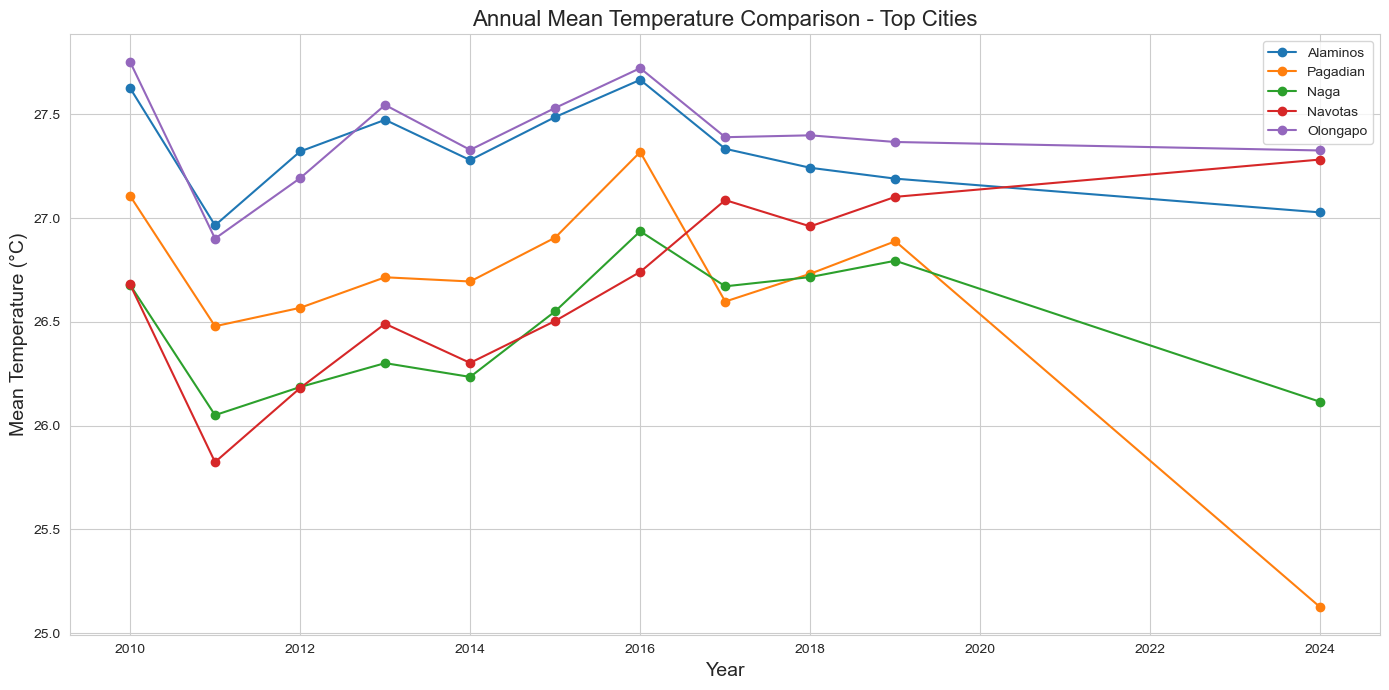

In [9]:
plt.figure(figsize=(14,7))
for city in top_cities:
    city_data = annual_city_anom[annual_city_anom['city_name']==city]
    plt.plot(city_data['year'], city_data['temperature_2m_mean'], marker='o', label=city)

plt.title("Annual Mean Temperature Comparison - Top Cities", fontsize=16)
plt.xlabel("Year", fontsize=14)
plt.ylabel("Mean Temperature (°C)", fontsize=14)
plt.legend()
plt.tight_layout()
plt.show()

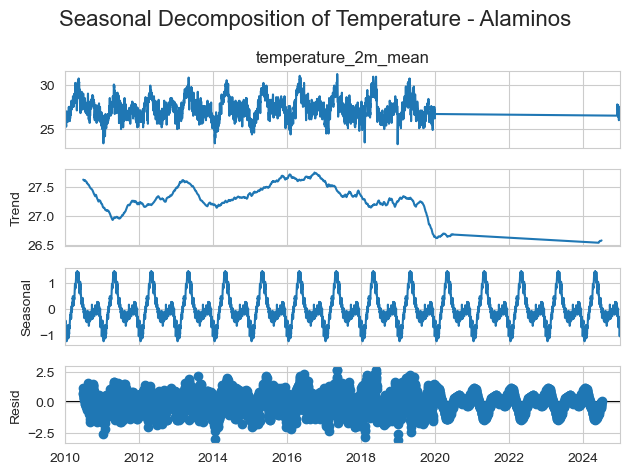

In [10]:
city_ts = df[df['city_name']==city_example].set_index('datetime')['temperature_2m_mean'].resample('D').mean().interpolate(method='time')
decomposition = sm.tsa.seasonal_decompose(city_ts, model='additive', period=365)
decomposition.plot()
plt.suptitle(f"Seasonal Decomposition of Temperature - {city_example}", fontsize=16)
plt.tight_layout()
plt.show()

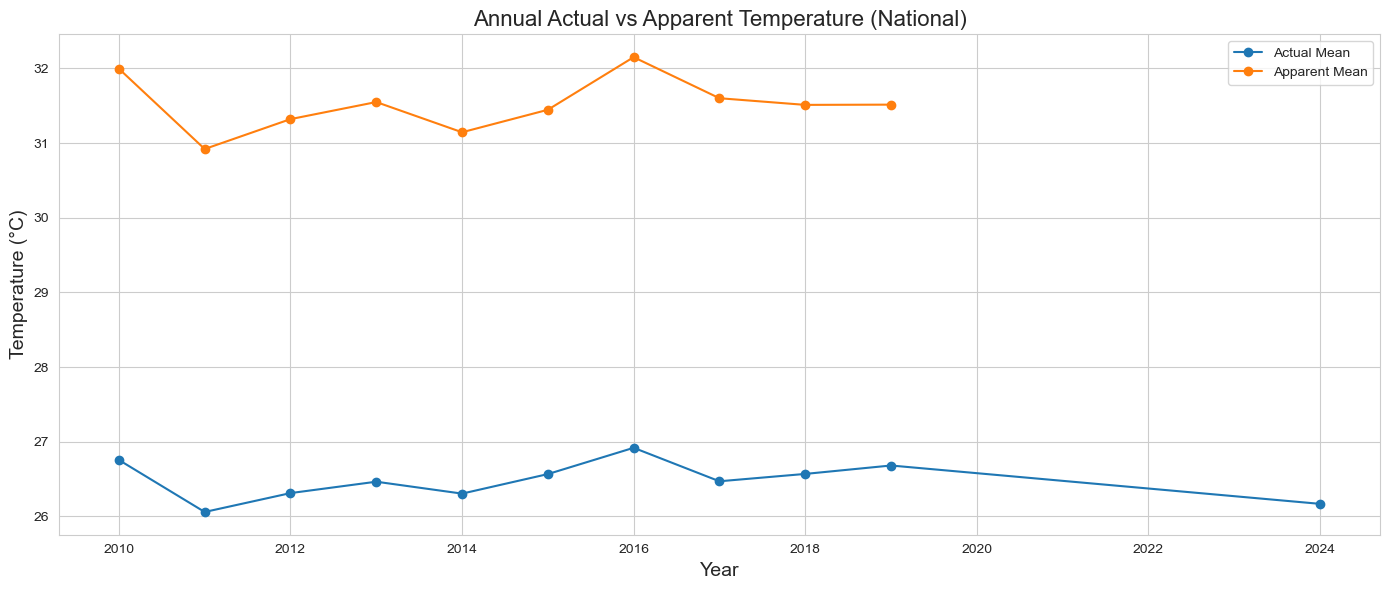

In [11]:
if 'apparent_temperature_max' in df.columns and 'apparent_temperature_min' in df.columns:
    df['apparent_temperature_mean'] = (df['apparent_temperature_max'] + df['apparent_temperature_min'])/2
    annual_app = df.groupby(['year'])[['temperature_2m_mean','apparent_temperature_mean']].mean().reset_index()

    plt.figure(figsize=(14,6))
    plt.plot(annual_app['year'], annual_app['temperature_2m_mean'], marker='o', label='Actual Mean')
    plt.plot(annual_app['year'], annual_app['apparent_temperature_mean'], marker='o', label='Apparent Mean')
    plt.title("Annual Actual vs Apparent Temperature (National)", fontsize=16)
    plt.xlabel("Year", fontsize=14)
    plt.ylabel("Temperature (°C)", fontsize=14)
    plt.legend()
    plt.tight_layout()
    plt.show()

In [12]:
annual_city_anom.to_csv("../data/processed/phil_temp_annual_city_anomalies.csv", index=False)
display(Markdown("Trend analysis and anomaly results saved to `data/processed/phil_temp_annual_city_anomalies.csv`"))

Trend analysis and anomaly results saved to `data/processed/phil_temp_annual_city_anomalies.csv`